# A grid of points, a grid of bases
This workbook is a first attempt at constructing a simulation of a stochastic dynamical system, with an accompanying estimation of the transfer operator.

In [1]:
include("functions.jl");

## Setting up the dynamics
The state space $X$ of our dynamical system will be the flat torus $\mathbb{T}^2$, represented by the square $[0, 2\pi] \times [0, 2\pi]$.

In [2]:
range = 2π;

For most numerical work, we will require a fine reference grid of points.

In [3]:
grid_size = 100;
n_gridpoints = grid_size ^ 2;
grid = creategrid(0, range, grid_size);

### A dynamical map
The particular map $S: \mathbb{T}^2 \to \mathbb{T}^2$ chosen to introduce the dynamics is the standard map, or Chirikov–Taylor map, given by
$$
S ([x , y]) := \begin{bmatrix} x + y \\ y + a \sin ( x + y) \end{bmatrix} \mod 2\pi
$$
where $a$ is a parameter which controls the 'amount of chaos'. For the moment we take this to be $a=6$.

In this setup, we have access to $S$. This means we can compute the images of whichever points $x \in X$ we like. For reasons which will later become clear, we will simply take a grid of data points.

In [4]:
sample_grid_size = 15;
sample_size = sample_grid_size ^ 2;
s = creategrid(0, range, sample_grid_size);

In [5]:
X = s;
Y = S(X);

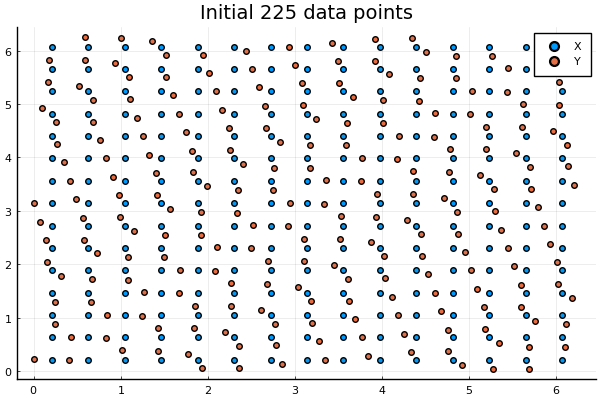

In [6]:
scatter(X[:,1], X[:,2]; label="X")
scatter!(Y[:,1], Y[:,2]; label="Y")
title!("Initial $sample_size data points")

## Estimating the transfer operator
Having established a model for the dynamics, next we want to estimate the corresponding transfer operator,
$$
\mathcal{P} : L^1(X) \to L^1(X) .
$$
In particular, we are interested in this operator in the stochastic setting, which can be characterised by the presence of a transition kernel density $K(\cdot, \cdot)$. This can be written as
$$
 \mathcal{P} f(y) = \int_X K(S(x), y ) f(x) \, \mathrm{d}x
$$
where $K(x, y) = \phi(x-y)$. 

To estimate this infinite-dimensional operator, we will need to work in a finite-dimensional subspace of $L^1(X)$, which we call $V$. Since $\mathcal{P}$ is linear, it will then suffice to compute its action on a basis for $V$. This will allow us to construct a square matrix $P$, which we will take to be our estimate of $\mathcal{P}$, in that $P(V) = \mathcal{P}(V)$.

### A finite basis
To compute $P$, we first must define a finite basis $V$ for $L^1(X)$. In this setup, we take this basis to be a uniform grid of $K$ Gaussian functions $\left\{ \varphi_i \right\}_{k=1}^K$ defined on the state space $K$. These will be of the form
$$
\varphi_k (x) = \phi ( x - z_k ) := \exp \left( - \frac{\| x - z_k \|^2}{\epsilon^2} \right)
$$
where the $z_k$ denote the centres of each function and $\epsilon$ is some bandwidth parameter. The set $\{\varphi_k \}_{k=1}^K$ is then taken as a basis for $V$.
$$
V = \operatorname{span} \left( \{\varphi_k \}_{k=1}^K \right)
$$

In fact, since the the data are already centered on a grid, we can just centre the basis functions on the datapoints. This means that $K=N$, and $z_k = x_n$.

In [7]:
basis_locs = X;
n_bases = sample_size;
basis_grid_size = sample_grid_size;

The value chosen for $\epsilon$ is an exogenous parameter, and will clearly influence the structure of $V$. To ensure good coverage of the state space, we will set this to be maximum nearest neighbour distance, which is simply the grid interval size. This will also affect the value of the integral $\int_X \varphi_k (x) \, \mathrm{d}x = c = \pi \epsilon^2$.

In [8]:
ϵ = range / basis_grid_size;
c = π * ϵ^2;

Having defined this basis $\{\varphi_k \}_{k=1}^K$, we can use it to approximate any function in $L^1(X)$ by simply taking linear combinations. For example:

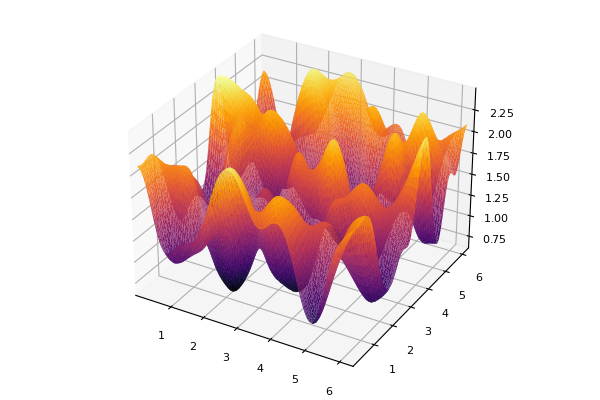

In [9]:
β = rand(n_bases);
test_surface = basis_combination(grid, basis_locs, φ, ϵ, β);
surface(grid[:,1], grid[:,2], test_surface; legend=false)

We will also be interested in the best possible approximation of the known invariant density for the standard map, which is the constant function (in this case, with value $f = \frac{1}{(2\pi)^2} \approx 0.025$). This is to say, we desire an approximation of Lebesgue measure with respect to the basis $\{ \varphi_i \}_{k=1}^K$. This can be solved for using least squares, but since the basis functions lie on a uniform grid, obviously all the scalars for this approximation $\{ \eta_i \}_{k=1}^K$ will just be equally weighted.

In [10]:
basis_surface = basis_combination(grid, basis_locs, φ, ϵ, ones(n_bases));
basis_surface_integral = (range)^2 * sum(basis_surface) / n_gridpoints;
η = ones(n_bases) / basis_surface_integral;

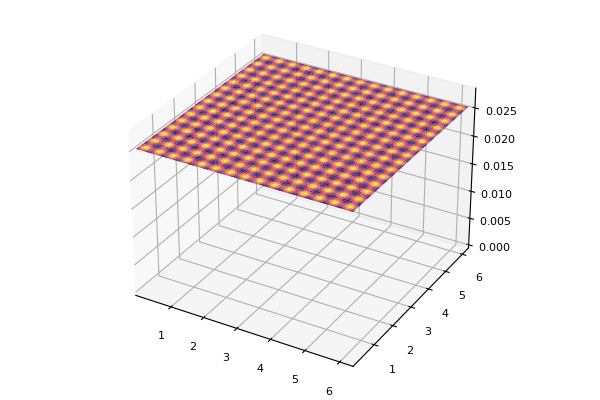

In [11]:
approximate_invariant_density= basis_combination(grid, basis_locs, φ, ϵ, η);
surface(grid[:,1], grid[:,2], approximate_invariant_density; legend=false)
zlims!(0,maximum(approximate_invariant_density)*1.1)

This looks pretty flat, which is good.

### Numerical integration
So we have chosen the subspace $V$. We can now estimate the integral
$$
    \mathcal{P} f(y) = \int_X k (S(x), y) f(x) \, \mathrm{d}x ,
$$
for some arbitrary function $f\in V$. Since we have a grid of datapoints available, we can simply assign uniform weights for each in the numerics.

In [12]:
w = ( range^2 / sample_size ) * ones(sample_size);

With these weights, we can now compute the integral $\mathcal{P}f(x)$. In particular, we are interested in computing $\mathcal{P}\varphi_n(x)$ for all $K= N$ basis functions, since this will clearly suffice in constructing $P$.
$$
\mathcal{P}\varphi_n(y) = \int_X K (S(x), y) \varphi_n(x) \, \mathrm{d}x
$$
For convenience, we will use the stochastic kernel $K (x, y) = \rho (x - y) = \frac{1}{c} \phi (x-y)$. Hence under the image points, $K(S(x) , y )$ becomes in effect an image of the basis functions, with $k(S(x_m), y) = \frac{1}{c} \varphi_{y_m}$. So our estimation of the above integral becomes the discrete sum
$$
\mathcal{P}\varphi_n(y) \approx \sum_{m=1}^N \frac{1}{c} \left( w_m \cdot \varphi_n (x_m) \right)  \varphi_{y_m} (y)
$$

Hence we can write each of the basis functions $\varphi_n$ as a linear combination of basis functions centered at the image points, $\{ \varphi_{y_n} \}_{n=1}^N$. But we obviously want to be able to write each $\mathcal{P} \varphi_n$ as just a linear combination of the $\varphi_n$. To do this, we will need to 'project' back onto the original subspace $H$ by writing each $\varphi_{y_m}$ itself as a linear combination of the $\varphi_n$.
$$
 \varphi_{y_m} (y) = \sum_{n=1}^N \gamma_n \varphi_n (y)
$$

Where do the weights $\gamma_n$ come from? We will need to calculate them according to a procedure suggested by Ding, Eifler, and Rhee. This says that
$$
\varphi_{y_m} (y) \approx Q \varphi_{y_m} (y) = \sum_{j=1}^N \left( \int_{V_j} c_j \varphi_{y_m} \right) \varphi_j (y) .
$$
Each of these integrals is computed over a Voronoi tesselation of the state space $X$, such that each $V_j$ corresponds to a particular basis function $\varphi_j$. What about the weights $c_j$? Per the same source, these must satisfy
\begin{align*}
    \sum_{j=1}^N \langle \varphi_j , \mathbb{1} \rangle c_j \mathbb{1}_{V_j} &= \mathbb{1} \\
    \sum_{j=1}^N c \cdot c_j \mathbb{1}_{V_j} &= \mathbb{1} \\
    \therefore c_j &= \frac{1}{c}
\end{align*}
so will be uniform across the integrals.

For the sake of computation, `integrate_phiy` is just used to compute the $N$ integral values for each image point, omitting the $c_j$. The results are stored in the matrix $\Xi$.

In [13]:
Ξ = integrate_phiy(Y, basis_locs, range, 100, φ, ϵ);

We will also need an evaluation matrix of all sample points against all basis functions, which we denote $\Phi$.

In [14]:
Φ = evaluate_funcs(X, basis_locs, φ, ϵ);

This is now everything we need to compute the matrix $P$.

In [15]:
P = construct_P(w, Φ, Ξ, c);

In [16]:
display(P)

225×225 Matrix{Float64}:
 0.000241567  0.000340788  0.000337977  …  0.00275903   0.00167244
 0.00145784   0.00025983   3.7736e-5       0.00918897   0.0137098
 0.0128284    0.00449743   0.000648283     0.0132468    0.0341343
 0.0333955    0.0197464    0.00602922      0.0142922    0.0234601
 0.0243323    0.029277     0.0154703       0.0279211    0.0137857
 0.0139041    0.0118222    0.010124     …  0.0206973    0.0149906
 0.015283     0.00326811   0.0023697       0.00517141   0.00596531
 0.00634934   0.00176552   0.00036939      0.000493206  0.000998004
 0.00108066   0.000702117  0.000187551     0.00318442   0.00156584
 0.00143877   0.00109252   0.000734233     0.03019      0.0145413
 0.0130044    0.00251365   0.00180973   …  0.0794196    0.0615929
 0.0586244    0.0126629    0.00219718      0.0536615    0.0904783
 0.0924518    0.0335268    0.00544732      0.0122048    0.0346
 ⋮                                      ⋱               
 0.0904783    0.0536615    0.0163921       0.0126629    0.

## Checking the results
Now that we have an estimate of $P$, we can start appraising it.

### Plotting the spectrum
We expect that $P$ should have a leading unit eigenvalue, and all the remaining eigenvalues should lie within the unit circle.

In [17]:
λ, Λ = ordered_eigendecomp(P);

In [18]:
display(λ[1])

1.0002069034459649 + 0.0im

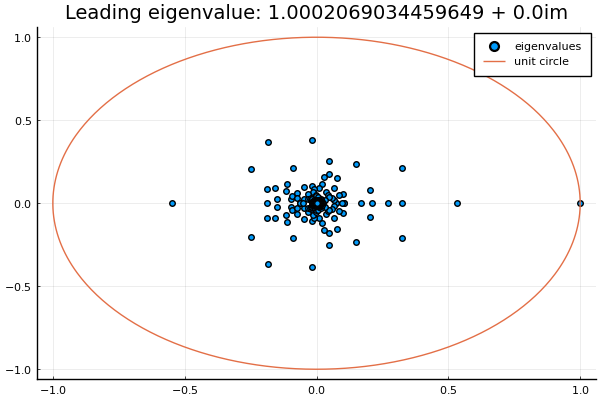

In [19]:
u, v = real.(λ), imag.(λ);
xc, yc = cos.(LinRange(0, 2π, 500)), sin.(LinRange(0, 2π, 500));

scatter(u, v, label="eigenvalues")
plot!(xc, yc, label="unit circle")
title!("Leading eigenvalue: $(λ[1])")

Happily, this is indeed the case.

### Row stochasticity
We also expect that the estimate should be row-stochastic, since by construction $P$ should be integral-preserving.

In [20]:
row_sums = sum(P, dims=2)[:];

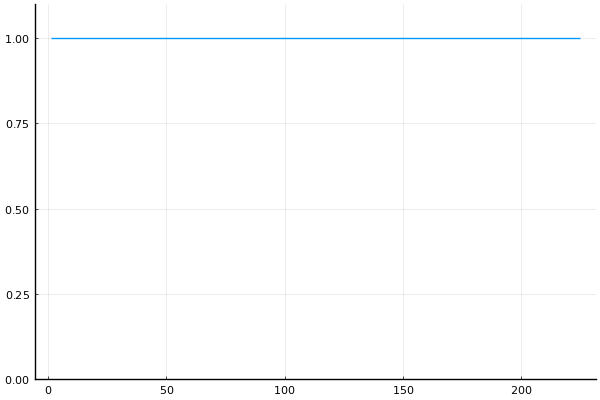

In [21]:
plot(row_sums; ylims=(0,1.1), legend=false)

Row sums are indeed constant; this value is of course the leading unit eigenvalue.

### Invariant density
We know that the leading eigenvector will specify the linear combination of basis functions which represents the invariant density. In our case, since we have defined a uniform grid of basis functions, we would hope to see that this vector was close to constant.

In [22]:
α = real.(Λ[:,1]);
α = abs.(α);

In [23]:
display(α)

225-element Vector{Float64}:
 0.0666666666666667
 0.06666666666666654
 0.06666666666666672
 0.0666666666666665
 0.06666666666666655
 0.06666666666666658
 0.06666666666666661
 0.06666666666666665
 0.06666666666666667
 0.06666666666666665
 0.0666666666666666
 0.06666666666666643
 0.0666666666666663
 ⋮
 0.06666666666666635
 0.06666666666666639
 0.06666666666666662
 0.06666666666666667
 0.0666666666666667
 0.06666666666666662
 0.06666666666666655
 0.06666666666666664
 0.0666666666666666
 0.06666666666666647
 0.06666666666666661
 0.06666666666666661

Good so far. We will nevertheless need to normalise the coordinates of this eigenvector such that it describes a density.

In [24]:
estimated_invariant_density = basis_combination(grid, basis_locs, φ, ϵ, α);
estimated_invariant_density_integral = ((range^2) / n_gridpoints) * sum(estimated_invariant_density);
α_normalised = α / estimated_invariant_density_integral;
estimated_invariant_density_normalised = basis_combination(grid, basis_locs, φ, ϵ, α_normalised); 

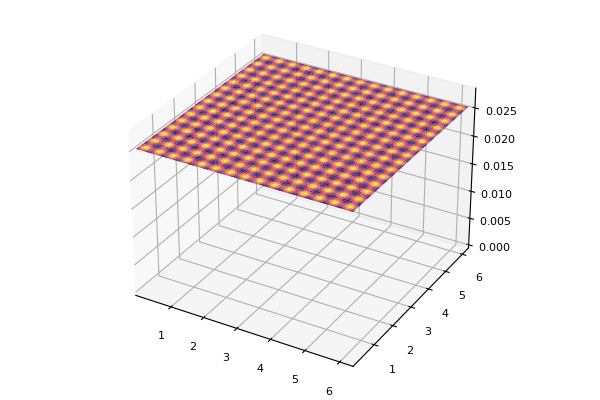

In [25]:
surface(grid[:,1], grid[:,2], estimated_invariant_density_normalised; legend=false)
zlims!(0, maximum(estimated_invariant_density_normalised)*1.1)

This looks pretty flat, which is good, since we know that the invariant density under the standard map is just the constant function. This result can be quantified by computing the $L^p$ norm of the difference between our estimated invariant density, denoted $\hat{f}^*$, and the known true invariant density, which we denote $f^*$. Or rather, we can compare $\hat{f}^*$ with the best possible representation of $f^*$ with respect to the basis we have chosen, which we denote $f^\dagger$.

In [26]:
estimation_gap = estimated_invariant_density_normalised - approximate_invariant_density;

In [27]:
estimation_l1 = Lp_norm(estimation_gap; p="one");
estimation_l2 = Lp_norm(estimation_gap; p="two");
estimation_l∞ = Lp_norm(estimation_gap; p="∞");

println("L1 norm of estimation difference: $estimation_l1")
println("L2 norm of estimation difference: $estimation_l2")
println("L∞ norm of estimation difference: $estimation_l∞")

L1 norm of estimation difference: 6.301225520146058e-16
L2 norm of estimation difference: 1.365110762757126e-16
L∞ norm of estimation difference: 9.367506770274758e-17


It is also interesting to compare $f^\dagger$ with the true invariant density, or constant function $f^*$.

In [28]:
constant_function = ones(n_gridpoints) / (range^2);

In [29]:
approximation_gap = approximate_invariant_density - constant_function;

In [30]:
approximation_l1 = Lp_norm(approximation_gap; p="one");
approximation_l2 = Lp_norm(approximation_gap; p="two");
approximation_l∞ = Lp_norm(approximation_gap; p="∞");

println("L1 norm of approximation difference: $approximation_l1")
println("L2 norm of approximation difference: $approximation_l2")
println("L∞ norm of approximation difference: $approximation_l∞")

L1 norm of approximation difference: 8.350319418169965e-5
L2 norm of approximation difference: 1.64640015356165e-5
L∞ norm of approximation difference: 5.176397725303178e-6


Looks like we have a pretty good approximation setup.

### Integral preservation and evolving forward a density
Last, we try directly evolving forward a density using $P$, and use this as an occasion to check that it indeed preserves integrals. We start with a random density function $f \in V$, where $f = \sum_{n=1}^N \beta_n \varphi_n$.

In [31]:
β = rand(n_bases)
initial_density = basis_combination(grid, basis_locs, φ, ϵ, β);
initial_density_integral = ( (range)^2  / n_gridpoints ) * sum(initial_density);
println("Estimate of initial integral: $initial_density_integral")

Estimate of initial integral: 63.73432311082484


In [32]:
β = β / initial_density_integral;
initial_density = basis_combination(grid, basis_locs, φ, ϵ, β);
initial_density_integral = ( (range)^2  / n_gridpoints ) * sum(initial_density);
println("Estimate of normalised integral: $initial_density_integral")

Estimate of normalised integral: 0.9999999999999999


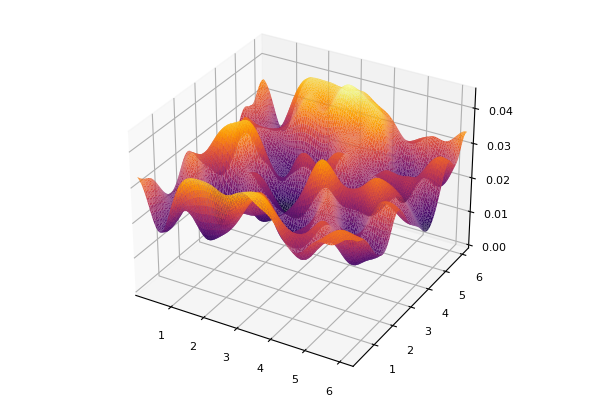

In [33]:
surface(grid[:,1], grid[:,2], initial_density; legend=false)
zlims!(0, maximum(initial_density)*1.1)

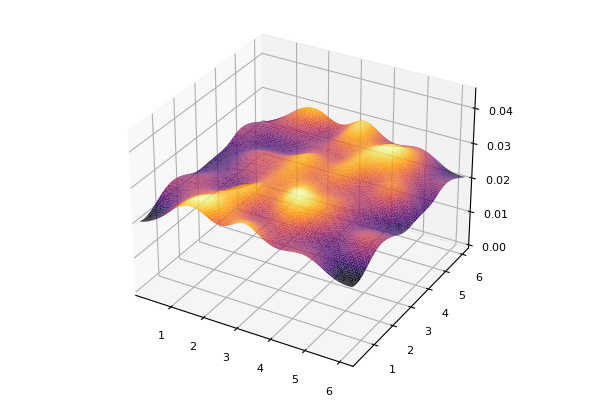

In [34]:
β1 = P * β;

evolved_density = basis_combination(grid, basis_locs, φ, ϵ, β1);
surface(grid[:,1], grid[:,2], evolved_density; legend=false)
zlims!(0, maximum(initial_density)*1.1)

In [35]:
evolved_integral = ( (range)^2 / n_gridpoints ) * sum(evolved_density);
println("Estimate of integral: $evolved_integral")

Estimate of integral: 1.0006054252278815


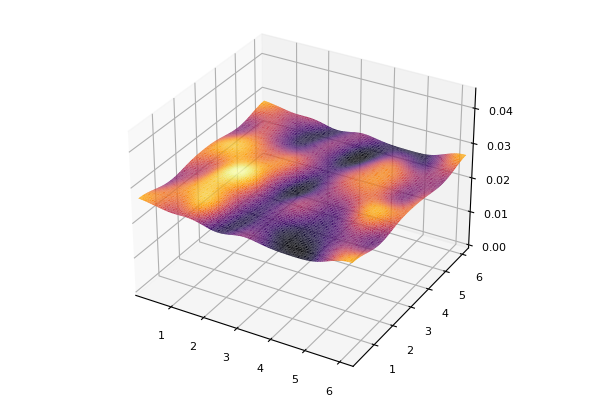

In [36]:
β2 = P * β1;

evolved_density = basis_combination(grid, basis_locs, φ, ϵ, β2);
surface(grid[:,1], grid[:,2], evolved_density; legend=false)
zlims!(0, maximum(initial_density)*1.1)

In [37]:
evolved_integral = ( (range)^2 / n_gridpoints ) * sum(evolved_density);
println("Estimate of integral: $evolved_integral")

Estimate of integral: 1.0010906810434554


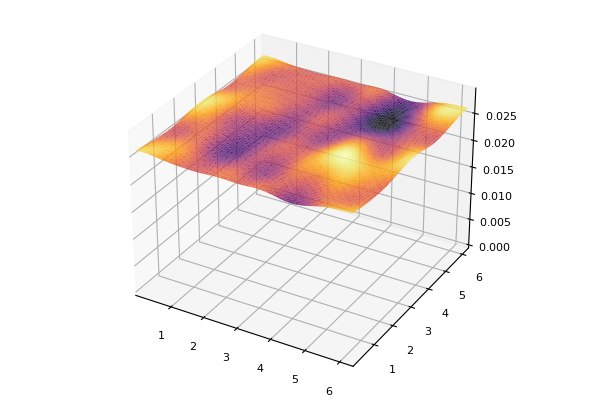

In [38]:
β3 = P * β2;

evolved_density = basis_combination(grid, basis_locs, φ, ϵ, β3);
surface(grid[:,1], grid[:,2], evolved_density; legend=false)
zlims!(0, maximum(evolved_density)*1.1)

In [39]:
evolved_integral = ( (range)^2 / n_gridpoints ) * sum(evolved_density);
println("Estimate of integral: $evolved_integral")

Estimate of integral: 1.00136771078698


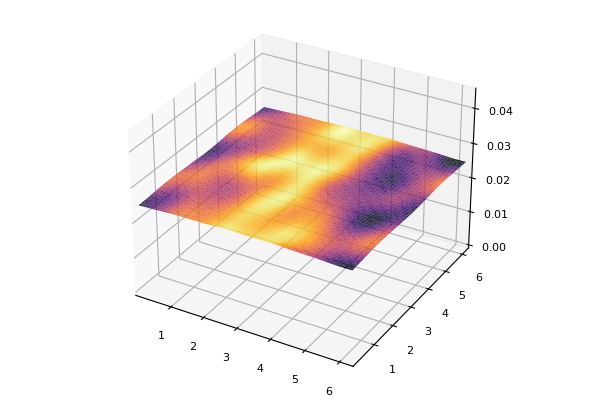

In [40]:
β4 = P * β3;

evolved_density = basis_combination(grid, basis_locs, φ, ϵ, β4);
surface(grid[:,1], grid[:,2], evolved_density; legend=false)
zlims!(0, maximum(initial_density)*1.1)

In [41]:
evolved_integral = ( (range)^2 / n_gridpoints ) * sum(evolved_density);
println("Estimate of integral: $evolved_integral")

Estimate of integral: 1.0015969970919576


After just four applications of $P$, we already see the limiting density start to emerge. Also, integrals are approximately preserved across each application.

## Conclusions
We have a reasonably functional procedure. Now it is time to experiment with different model parameters.